In [ ]:
# kaggle dataset library
! pip install -q kaggle

In [ ]:
# Download Kaggle.json file
# 1) Login in to Kaggle.com
# 2) Go to 'profile' section select 'your account'
# 3) Create New API Token
# 4) Kaggle.json file will be downloaded
# 5) Run Below code cell and upload your Kaggle.json file from your system

In [ ]:
# upload kaggle.json
from google.colab import files
files.upload()

In [ ]:
# Making a dir for kaggle
! mkdir ~/.kaggle 
# Copying kaggle.json to kaggle dir
! cp kaggle.json ~/.kaggle/
# Make directory named kaggle and copy kaggle.json file there.
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Testing kaggle loaded successfully or not
# ! kaggle datasets list

ref                                                             title                                             size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  -----------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
meirnizri/covid19-dataset                                       COVID-19 Dataset                                   5MB  2022-11-13 15:47:17          11368        336  1.0              
michals22/coffee-dataset                                        Coffee dataset                                    24KB  2022-12-15 20:02:12           2181         61  1.0              
thedevastator/jobs-dataset-from-glassdoor                       Salary Prediction                                  3MB  2022-11-16 13:52:31           7111        151  1.0              
thedevastator/unlock-profits-with-e-commerce-sales-data         E-Commerce 

In [ ]:
# Donwload kaggle dataset 
!kaggle datasets download -d moltean/fruits

 99% 1.27G/1.28G [00:06<00:00, 253MB/s]
100% 1.28G/1.28G [00:06<00:00, 205MB/s]


In [ ]:
!unzip 'fruits.zip' 

In [ ]:
# HuggingFace's Transformers library
!pip install transformers 

In [ ]:
# Import libraries

# Pytorch
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
from torchvision import transforms

import os
import numpy as np
from glob import glob

# Build up the pretrained transformers model
from transformers import ViTFeatureExtractor, ViTModel

# Plot tool
import matplotlib.pyplot as plt

In [ ]:
# Setting up Device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

In [ ]:
# Set up device and training hyperparameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 256
latent_dim = 256
epochs = 3
learning_rate = 5e-4

In [ ]:
# Add the transformation of image
data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Normalize((0.5,)*3, (0.5,)*3)
])

In [ ]:
# Path for training and validation dataset

# base_dir contains path to the dataset directory
base_dir = "/content/fruits-360-original-size/fruits-360-original-size/"

# Create train dataset and Dataloader
training_path = base_dir + "Training/"
training_dataset = ImageFolder(training_path, transform = data_transforms)
training_dataloader = DataLoader(training_dataset, batch_size = batch_size, shuffle = True)

# Create validation dataset and Dataloader
validating_path = base_dir + "Validation/"
validating_dataset = ImageFolder(validating_path, transform = data_transforms)
val_dataloader = DataLoader(validating_dataset, batch_size = batch_size, shuffle = True)

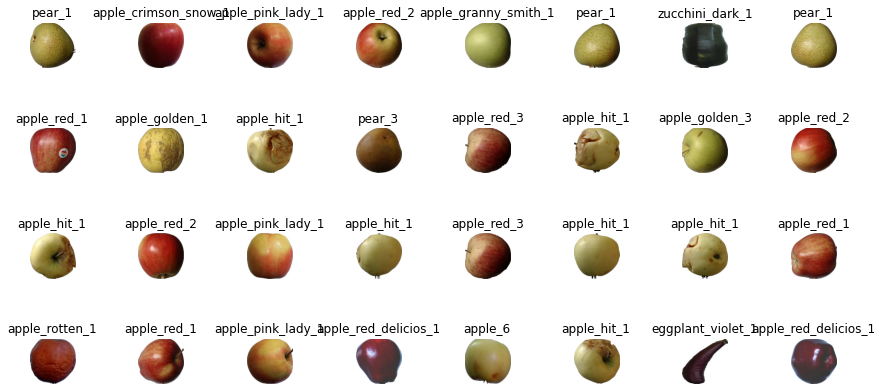

In [ ]:
image_size = 32

# Get the image from dataloader
show_images, show_labels = next(iter(training_dataloader))
show_images = show_images[:image_size]
show_labels = show_labels[:image_size]

ncols = 8
nrows = image_size // ncols

# Set up the figure size
plt.figure(figsize=(12, 6))


def inverse_normalized(image):
    # Clamp the value to (0.0, 1.0) for floats
    image = torch.clamp(input = image * 0.5 + 0.5, min = 0.0, max = 1.0)
    return image


for idx in range(len(show_images)):
    # Set up the subplot
    plt.subplot(nrows, ncols, idx + 1)
    
    # Close the axis and plot the image
    plt.axis("off")
    # Note that the label is change into integer, we should change it back to category
    plt.title(training_dataset.classes[show_labels[idx].item()])
    # Note that the image channel of tensor is: (channel, width, height)
    # We need to change it to (width, height, channel) which we use permute to realize it
    plt.imshow(inverse_normalized(show_images[idx].permute(1, 2, 0)))

# Avoid overlapping of different titles
plt.tight_layout()

In [ ]:
# Model 
class CategoryClass(nn.Module):
    def __init__(self, vit, latent_dim, classes_):
        super(CategoryClass, self).__init__()
        
        self.classes_ = classes_
        
        # Set up model architecture
        self.vit = vit
        self.fc_1 = nn.Linear(768, latent_dim)
        self.fc_out = nn.Linear(latent_dim, self.classes_)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, in_data):
        # Type of output `BaseModelOutputWithPooling`
        vit_outputs = self.vit(in_data)
        
        # Shape of pooler_output: (batch_size, hidden_size)
        pooler_output = vit_outputs.pooler_output
        
        # Pass through the linear layout to predict the class
        # Shape of output: (batch_size, classes_)
        outputs = torch.relu(self.fc_1(pooler_output))
        outputs = self.fc_out(self.dropout(outputs))
        
        return outputs

In [ ]:
# Set up the pretrained model
vit = ViTModel.from_pretrained('google/vit-base-patch16-224')

Downloading:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of the model checkpoint at google/vit-base-patch16-224 were not used when initializing ViTModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Freeze the layers in vit exclude the pooler layers
for param in vit.parameters():
    param.requires_grad = False

vit.pooler.dense.weight.requires_grad = True
vit.pooler.dense.bias.requires_grad = True

In [ ]:
# Create the complete model
model = CategoryClass(vit, latent_dim, len(training_dataset.classes)).to(device)

In [ ]:
# Set up loss function and optimizers
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), learning_rate)

In [ ]:
model_path = '/kaggle/working/model.pt'

if not os.path.exists(model_path):
    
    # Save the training and validating information
    training_loss_history =[]
    training_accuracy_history = []
    validating_loss_history = []
    validating_accuracy_history = []

    # We save the batch information
    batch_loss_history = []
    batch_accuracy_history = []
    epochs = 3

    for epoch in range(epochs):
        # Set to the train mode
        model.train()

        train_epoch_loss = 0.0
        train_epoch_accuracy = 0.0
        for idx, (images, labels) in enumerate(training_dataloader):
            # Move the data to the device
            images = images.to(device)
            labels = labels.to(device)

            # Pass through the model
            outputs = model(images)

            # Count the loss and update the parameters
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Record the training information
            train_epoch_loss += loss.item()
            predict_class = outputs.argmax(dim=-1)
            accuracy = torch.sum(predict_class == labels).item() / labels.shape[0]
            train_epoch_accuracy += accuracy

            # Save the batch information
            batch_loss_history.append(loss.item())
            batch_accuracy_history.append(accuracy)

            # Print batch information
            print(f"Batch {idx + 1} in epoch {epoch + 1}/{epochs}")
            print(f"Average loss: {loss.item()}")
            print(f"Average accuracy {accuracy}")

        # Set to the eval mode
        model.eval()

        val_epoch_loss = 0.0
        val_epoch_accuracy = 0.0

        with torch.no_grad():
            for val_images, val_labels in val_dataloader:
                # Move data to the device
                val_images = val_images.to(device)
                val_labels = val_labels.to(device)

                # Pass through model
                val_outputs = model(val_images)

                # Count the loss and accuracy
                val_epoch_loss += criterion(val_outputs, val_labels)
                val_predict_class = val_outputs.argmax(dim=-1)
                val_epoch_accuracy += torch.sum(val_predict_class == val_labels).item() / val_labels.shape[0]

        # Save the epoch information
        training_loss_history.append(train_epoch_loss / len(training_dataloader))
        training_accuracy_history.append(train_epoch_accuracy / len(training_dataloader))
        validating_loss_history.append(val_epoch_loss / len(val_dataloader))
        validating_accuracy_history.append(val_epoch_accuracy / len(val_dataloader))

        # Print the information
        print(f"Epoch {epoch + 1}")
        print(f"Average training loss: {training_loss_history[-1]}, Average validation loss: {validating_loss_history[-1]}")
        print(f"Average training accuracy: {training_accuracy_history[-1]}, Average validation accuracy: {validating_accuracy_history[-1]}")

        # Save the model weight
        torch.save(model.state_dict(), "model.pt")
        
        # Plot the loss and accuracy
        plt.figure(figsize=(18,6))

        # Loss
        plt.subplot(1, 2, 1)
        plt.title("Loss for batch")
        plt.xlabel("Batch")
        plt.ylabel("Loss")
        plt.plot(batch_loss_history)

        # Accuracy
        plt.subplot(1, 2, 2)
        plt.title("Accuracy for batch")
        plt.xlabel("Batch")
        plt.ylabel("Accuracy")
        plt.plot(batch_accuracy_history)

else:
    model_weight = torch.load(model_path)
    
    model.load_state_dict(model_weight)

In [ ]:
prediction = []
true_labels = []

# Create the classification report on test dataset
with torch.no_grad():
    for val_images, val_labels in val_dataloader:
        # Move data to the device
        val_images = val_images.to(device)
        val_labels = val_labels.to(device)
        
        # Pass through model
        val_outputs = model(val_images)
        #print(val_outputs)
        
        # Count the loss and accuracy
        val_predict_class = val_outputs.argmax(dim=-1)
        #print(val_predict_class)

        prediction.extend([predict_class.item() for predict_class in val_predict_class])
        true_labels.extend([val_label.item() for val_label in val_labels])

In [ ]:
import pandas as pd
from sklearn.metrics import classification_report

# Output dict for making the report
report = classification_report(true_labels, prediction, output_dict=True, target_names=training_dataset.classes)
report_df = pd.DataFrame(report).transpose()

In [ ]:
# Show all columns
pd.set_option("display.max_rows", None)
report_df

,precision,recall,f1-score,support
apple_6,1.0,1.0,1.0,158.0
apple_braeburn_1,1.0,1.0,1.0,160.0
apple_crimson_snow_1,1.0,1.0,1.0,159.0
apple_golden_1,1.0,1.0,1.0,154.0
apple_golden_2,1.0,1.0,1.0,154.0
apple_golden_3,1.0,1.0,1.0,158.0
apple_granny_smith_1,1.0,1.0,1.0,160.0
apple_hit_1,1.0,1.0,1.0,234.0
apple_pink_lady_1,1.0,1.0,1.0,156.0
apple_red_1,1.0,1.0,1.0,155.0


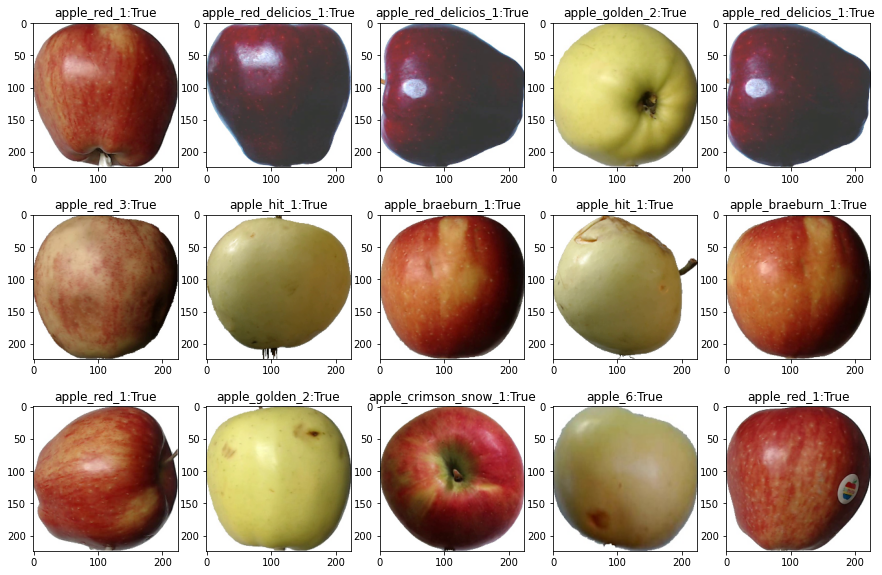

In [ ]:
def img_display(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.cpu().numpy()
    npimg = np.transpose(npimg, (1, 2, 0))
    return npimg


dataiter = iter(val_dataloader)
images, labels = next(dataiter) 
images = images.to(device)
labels = labels.to(device)
        
types=training_dataset.classes
# Viewing data examples used for training
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
with torch.no_grad():
    model.eval()
    for ax, image, label in zip(axis.flat,images, labels):
        ax.imshow(img_display(image)) # add image
        image_tensor = image.unsqueeze_(0)
        output_ = model(image_tensor)
        output_ = output_.argmax()
        k = output_.item()==label.item()
        ax.set_title(str(types[label.item()])+":" +str(k)) # add label

In [ ]:
# test_path="../input/sample-fruitsveg"
test_path = base_dir + "Test/"
# test_path = "/kaggle/input/fruits/fruits-360_dataset/fruits-360/Test/"

test_dataset = ImageFolder(test_path, transform=data_transforms)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
dataiter = iter(test_dataloader)
test_dataset

Dataset ImageFolder
    Number of datapoints: 3110
    Root location: /content/fruits-360-original-size/fruits-360-original-size/Test/
    StandardTransform
Transform: Compose(
               ToTensor()
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

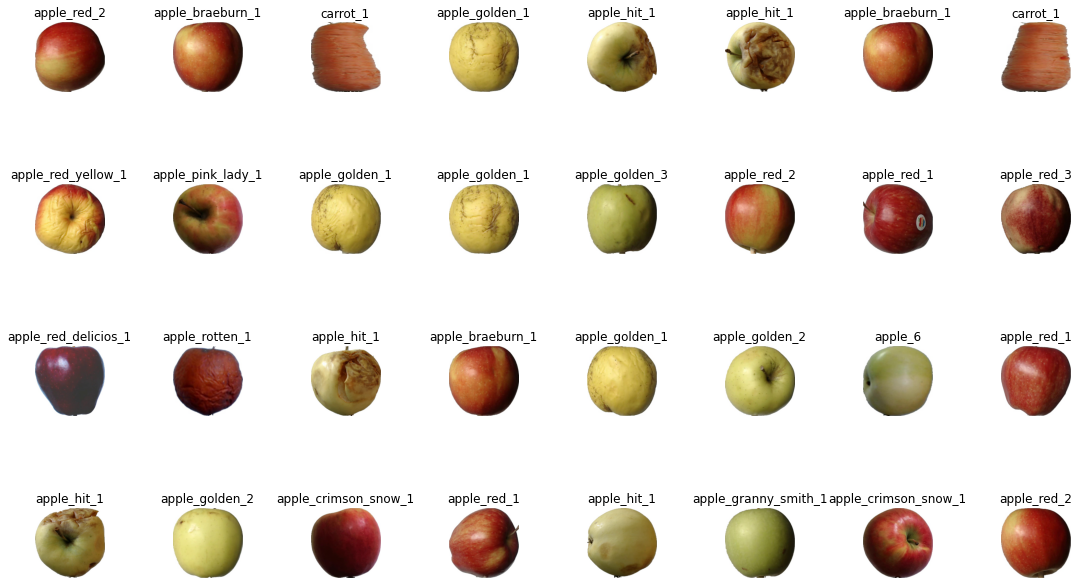

In [ ]:
images, labels = next(dataiter) #dataiter.next()

if len(images) > 32:
    images = images[:32]
    labels = labels[:32]

image_size = len(images)
ncols = 8
nrows = image_size // ncols + 1

images = images.to(device)
labels = labels.to(device)

types = training_dataset.classes
        
with torch.no_grad():
    model.eval()
    plt.figure(figsize=(15, 12), tight_layout=True)
    for idx in range(len(images)):
        # Set up the subplot
        plt.subplot(nrows, ncols, idx + 1)
        
        # Close the axis and plot the image
        plt.axis("off")
        
        image_tensor = images[idx].unsqueeze(0)
        output_ = model(image_tensor)
        output_ = output_.argmax(dim=-1)
       
        plt.title(training_dataset.classes[output_.item()])
        plt.imshow(img_display(images[idx]))

In [ ]:
# Download Model
# from google.colab import files
# files.download('model.pt') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>